In [1]:
from dask.diagnostics import ProgressBar
from dask.distributed import Client
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer, PorterStemmer

import dask.dataframe as dd
import html
import matplotlib.pyplot as plt
import numpy as np
import psutil
import pandas as pd
import pickle as pkl
import re
import time

In [2]:
# Read the data
df_comments_1 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_1.pkl')
df_comments_2 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_2.pkl')
df_comments_3 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_3.pkl')
df_comments_4 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_4.pkl')
df_comments_5 = pd.read_pickle('C:/Users/Julia/Downloads/comments_typecasted_5.pkl')

df_comments = pd.concat([df_comments_1, df_comments_2, df_comments_3, df_comments_4, df_comments_5])

df_posts_1 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_1.pkl')
df_posts_2 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_2.pkl')
df_posts_3 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_3.pkl')
df_posts_4 = pd.read_pickle('C:/Users/Julia/Downloads/posts_typecasted_4.pkl')

df_topics_1 = pd.read_pickle('C:/Users/Julia/Downloads/picklefiles/posts_with_topic_1.pkl')
df_topics_2 = pd.read_pickle('C:/Users/Julia/Downloads/picklefiles/posts_with_topic_2.pkl')
df_topics_3 = pd.read_pickle('C:/Users/Julia/Downloads/picklefiles/posts_with_topic_3.pkl')
df_topics_4 = pd.read_pickle('C:/Users/Julia/Downloads/picklefiles/posts_with_topic_4.pkl')

df_posts = pd.concat([df_posts_1,df_posts_2,df_posts_3,df_posts_4])
df_topics = pd.concat([df_topics_1,df_topics_2,df_topics_3,df_topics_4])

df_users = pd.read_pickle('C:/Users/Julia/Documents/CompTools/users_typecasted.pkl')
df_users = df_users.loc[df_users['Id'] > 0]

In [3]:
df_posts

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount
150,307,2,260,-1,2008-08-02 01:49:46.220,43,-1,"<p><a href=""https://www.codeproject.com/Articl...",49,2019-12-24 07:28:19.907,Comment: N/A,Comment: N/A,-1,3
160,337,1,-1,342,2008-08-02 03:35:55.697,82,10424,<p>I am about to build a piece of a project th...,111,2021-11-12 18:56:21.143,XML Processing in Python,<python><xml>,12,1
162,342,2,337,-1,2008-08-02 04:01:34.600,36,-1,"<p>Personally, I've played with several of the...",59,2008-08-02 04:01:34.600,Comment: N/A,Comment: N/A,-1,1
195,469,1,-1,3040,2008-08-02 15:11:16.430,48,4837,<p>I am using the Photoshop's javascript API t...,147,2022-12-15 07:51:30.287,How can I find the full path to a font from it...,<python><macos><fonts><photoshop>,6,0
197,471,2,337,-1,2008-08-02 15:21:03.587,33,-1,"<p><a href=""http://effbot.org/zone/element-ind...",147,2008-08-02 15:21:03.587,Comment: N/A,Comment: N/A,-1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59171855,77031662,1,-1,-1,2023-09-03 09:21:50.950,0,9,<p>Write a Python function named bookStore tha...,22491996,2023-09-03 09:21:50.950,How do I make sure I'm only taking a certain v...,<python><function><dictionary>,0,1
59171857,77031664,1,-1,-1,2023-09-03 09:22:27.673,-1,7,<p>i have a problem with updating the text box...,21080209,2023-09-03 09:22:27.673,Updating Textbox on a real time Chat,<python><function><pycharm><chat>,0,0
59171873,77031681,1,-1,-1,2023-09-03 09:28:20.777,0,5,<p>I've setup a django cms site for a friend s...,5568154,2023-09-03 09:28:20.777,Django CMS cms_plugin setup for a message form...,<django><django-cms>,0,0
59171876,77031684,1,-1,-1,2023-09-03 09:30:08.627,0,11,<p>I think I'm having an integer overflow issu...,9884278,2023-09-03 09:34:06.857,Integer Overflow when Passing Arguments in C,<c><integer-overflow>,1,1


### Filter active users (>50 posts/comments)

In [4]:
# Filtering posts to include only questions and answers
filtered_posts_df = df_posts[df_posts['PostTypeId'].isin([1, 2])]

# Calculating post and comment counts for each user
user_posts_count = filtered_posts_df[filtered_posts_df['PostTypeId'] == 1].groupby('OwnerUserId').size().rename('PostCount')
user_answers_count = filtered_posts_df[filtered_posts_df['PostTypeId'] == 2].groupby('OwnerUserId').size().rename('AnswerCount')
user_comments_count = df_comments.groupby('UserId').size().rename('CommentCount')

#Calculating the number of accepted answers for each user
accepted_answers_ids = set(filtered_posts_df[(filtered_posts_df['PostTypeId'] == 1) & (filtered_posts_df['OwnerUserId'] > -1)]['AcceptedAnswerId'])
user_accepted_answers_count = filtered_posts_df[filtered_posts_df['Id'].isin(filtered_posts_df[filtered_posts_df['AcceptedAnswerId'] > 0]['AcceptedAnswerId'])].groupby('OwnerUserId').size().rename('AcceptedAnswerCount')


# Merging counts with user data and filling missing values
user_data = df_users.merge(user_posts_count, left_on='Id',  right_on='OwnerUserId', how='left') \
                    .merge(user_comments_count, left_on='Id', right_on='UserId', how='left') \
                    .merge(user_accepted_answers_count, left_on='Id', right_on='OwnerUserId', how='left') \
                    .merge(user_answers_count, left_on='Id', right_on='OwnerUserId', how='left') \
                    .fillna({'PostCount': 0, 'CommentCount': 0, 'AcceptedAnswerCount': 0, 'AnswerCount': 0})

# Adding a column for total activity and filtering for active users
active_users = user_data.assign(TotalActivity=lambda x: x['PostCount'] + x['CommentCount'] + x['AnswerCount'])
active_users = active_users[active_users['TotalActivity'] > 50]
active_users = active_users.sample(frac=0.1)

# Creating a set of active user IDs
active_user_ids = set(active_users['Id'])

# Filtering dataframes for active user activity
filtered_active_posts_df = filtered_posts_df[filtered_posts_df['OwnerUserId'].isin(active_user_ids)]

# Identifying posts where the parent post is owned by an active user
parent_posts_of_active_users = filtered_posts_df[filtered_posts_df['ParentId'].isin(filtered_active_posts_df['Id'])]

# Including these posts in the filtered_active_posts_df
filtered_active_posts_df = pd.concat([filtered_active_posts_df, parent_posts_of_active_users]).drop_duplicates()

# Gathering Post IDs and Parent IDs for active users
active_user_post_ids = set(filtered_active_posts_df['Id'])
active_user_answers = filtered_posts_df[(filtered_posts_df['PostTypeId'] == 2) & (filtered_posts_df['OwnerUserId'].isin(active_user_ids))]
active_user_answer_parent_ids = set(active_user_answers['ParentId'])

# Average answer and post score for each user
avg_answer_score = active_user_answers.groupby('OwnerUserId')['Score'].mean().rename('AvgAnswerScore')
avg_post_score = filtered_active_posts_df[filtered_active_posts_df['PostTypeId'] == 1].groupby('OwnerUserId')['Score'].mean().rename('AvgPostScore')


active_users = active_users.merge(avg_answer_score, left_on='Id', right_on='OwnerUserId', how='left').fillna({'AvgAnswerScore': 0}) \
    .merge(avg_post_score, left_on='Id', right_on='OwnerUserId', how='left').fillna({'AvgPostScore': 0})
active_users['AcceptedAnswerFraction'] = active_users['AcceptedAnswerCount'] / active_users['AnswerCount']

# Filtering comments for active users and their related posts
filtered_comments = df_comments[(df_comments['PostId'].isin(active_user_answers['Id']))].drop_duplicates()

# Printing shapes for comparison
print("Questions DataFrame shape:", df_posts.shape)
print("Filtered Questions DataFrame shape:", filtered_active_posts_df.shape, '\n')

print("Comments DataFrame shape:", df_comments.shape)
print("Filtered Comments DataFrame shape:", filtered_comments.shape, '\n')

Questions DataFrame shape: (3802836, 14)
Filtered Questions DataFrame shape: (216559, 14) 

Comments DataFrame shape: (47612714, 6)
Filtered Comments DataFrame shape: (141597, 6) 


In [5]:
print(f"Sample of users: {len(active_users['Id'].unique())}, fraction of total: {len(active_users['Id'].unique()) / len(df_users['Id'].unique())}")
print(f"Sampled users authored, answered or commented {len(filtered_active_posts_df['Id'].unique())} posts, fraction of total: {len(filtered_active_posts_df['Id'].unique()) / len(df_posts['Id'].unique())}")

Sample of users: 11810, fraction of total: 0.010574818858098646
Sampled users authored, answered or commented 216559 posts, fraction of total: 0.05694671029726236


### Option: Filter posts from Recent year (maybe less deleted users)

In [13]:
# Convert 'CreationDate' to datetime format once for the main DataFrames
df_comments['CreationDate'] = pd.to_datetime(df_comments['CreationDate'])
df_posts['CreationDate'] = pd.to_datetime(df_posts['CreationDate'])

# Identify deleted comments and posts
deleted_comments = df_comments[df_comments['UserId'] == -1]
deleted_posts = df_posts[df_posts['OwnerUserId'] == -1]

# Resample and count deleted entries every half year
semi_annual_deleted_comments = deleted_comments.resample('6M', on='CreationDate').count()['Id']
semi_annual_deleted_posts = deleted_posts.resample('6M', on='CreationDate').count()['Id']

# Resample and count total entries every half year
semi_annual_total_comments = df_comments.resample('6M', on='CreationDate').count()['Id']
semi_annual_total_posts = df_posts.resample('6M', on='CreationDate').count()['Id']

# Calculate the percentage of deleted comments and posts (handling division by zero)
semi_annual_deleted_comments_percentage = (semi_annual_deleted_comments / semi_annual_total_comments.replace(0, np.nan)) * 100
semi_annual_deleted_posts_percentage = (semi_annual_deleted_posts / semi_annual_total_posts.replace(0, np.nan)) * 100

# Combine the results into a single DataFrame for visualization
semi_annual_percentage = pd.DataFrame({
    'Deleted Comments (%)': semi_annual_deleted_comments_percentage,
    'Deleted Posts (%)': semi_annual_deleted_posts_percentage
}).fillna(0)  # fill NaN with 0 (in case of divisions by zero)

# Formatting the index for better readability
semi_annual_percentage.index = semi_annual_percentage.index.strftime('%Y-%m')

# Displaying the DataFrame
semi_annual_percentage.head()

,Deleted Comments (%),Deleted Posts (%)
CreationDate,,
2008-08,0.0,1.358234
2009-02,0.0,4.853264
2009-08,0.0,5.904742
2010-02,0.0,2.602338
2010-08,0.0,1.600119


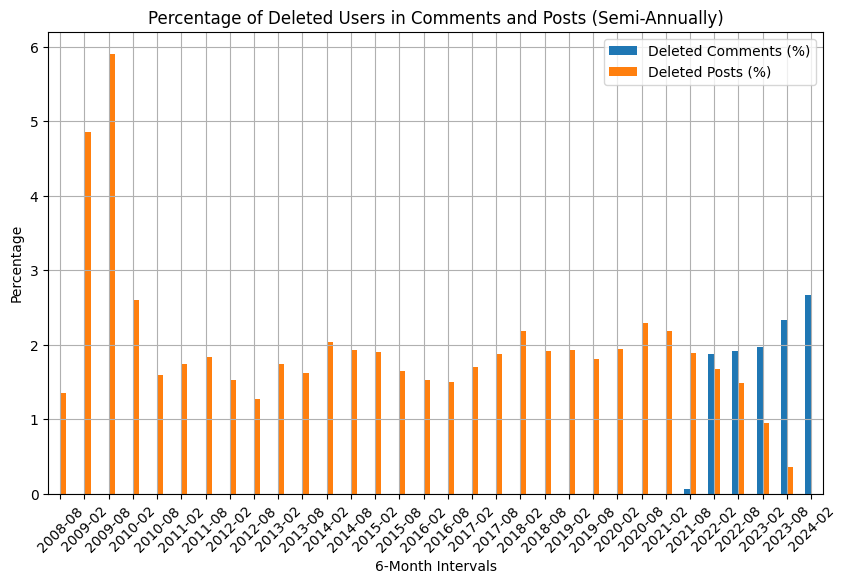

In [14]:
# Plotting the data
plt.figure(figsize=(10, 6))
semi_annual_percentage.plot(kind='bar', ax=plt.gca())
plt.title('Percentage of Deleted Users in Comments and Posts (Semi-Annually)')
plt.xlabel('6-Month Intervals')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

### Filtering before the storm

In [6]:
print(filtered_comments.shape)
print(filtered_active_posts_df.shape)

# Removing entries with -1 in UserId and OwnerUserId columns
#filtered_comments = filtered_comments[filtered_comments['UserId'] != -1]

filtered_active_posts_df = filtered_active_posts_df[filtered_active_posts_df['OwnerUserId'] != -1]

print(filtered_comments.shape)
print(filtered_active_posts_df.shape)

(42199170, 6)
(1865160, 14)
(42092110, 6)
(1797023, 14)


### Preprocess text

In [6]:
# Modify preprocess_text function
def preprocess_text(text, remove_stopwords=False, use_lemmatize=True, use_stemmer=False):
    # Handle None or non-string inputs
    if not isinstance(text, str):
        return ""
        
    # Decode HTML entities
    text = html.unescape(text)

    # Remove HTML tags
    text = re.sub(r'<[^>]+>', '', text)

    # Remove non-alphanumeric characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text.lower())

    words = text.split()
    if remove_stopwords:
        words = [word for word in words if word not in stopwords.words('english')]
    if use_lemmatize:
        lemmatizer = WordNetLemmatizer()
        words = [lemmatizer.lemmatize(word) for word in words]
    elif use_stemmer:  # Apply stemming only if use_stemmer is True
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]

    text = ' '.join(words)
    
    return text

In [7]:
# Preprocess Title, Body, and Tags using Dask DataFrames
# Convert the DFs to Dask DataFrames
ddf_comments = dd.from_pandas(filtered_comments, npartitions=8)

In [8]:
# Preprocess Columns
ddf_comments['Text_Processed'] = ddf_comments['Text'].map_partitions(lambda x: x.apply(lambda y: preprocess_text(y, remove_stopwords=True, use_lemmatize=True, use_stemmer=False)))

# Convert back to pandas DataFrame
df_comments_processed = ddf_comments.compute()

### Estimate memory usage

In [9]:
# Initialize SentimentIntensityAnalyzer once
sia = SentimentIntensityAnalyzer()

# Function to apply sentiment analysis
def analyze_sentiment(text):
    # Check if the text is missing or NaN, return 0.0 in such cases
    if pd.isna(text):
        return 0.0
    # Ensure the text is encoded as a string
    text = str(text)
    return sia.polarity_scores(text)['compound']

### Sentiment Analysis

In [10]:
# Convert pandas DataFrame to Dask DataFrame
df_comments_dask = dd.from_pandas(df_comments_processed, npartitions=8)  # Adjust npartitions based on memory usage results
#df_posts_dask = dd.from_pandas(df_posts_processed, npartitions=8)  # Adjust npartitions based on memory usage results

# Apply sentiment analysis
df_comments_dask['Text_sentiment'] = df_comments_dask['Text'].map(analyze_sentiment)

In [11]:
with ProgressBar():
    df_comments_result = df_comments_dask.compute()

[########################################] | 100% Completed | 26.71 ss


In [12]:
df_comments_result.sort_values(by='Text_sentiment', ascending=False)

,Id,PostId,Score,Text,CreationDate,UserId,Text_Processed,Text_sentiment
24728857,36412576,23696753,0,Oh look it's finally working after 3 hours! Ev...,2014-05-16 14:05:58.440,3399642,oh look finally working 3 hour even though sti...,0.9898
80775184,122194928,69136504,0,"Wow, what an amazing explanation: very calm, c...",2021-09-10 19:45:27.787,16870652,wow amazing explanation calm clean step step e...,0.9897
6031197,8839325,7321948,0,Well I didn't want to do so because it's flame...,2011-09-07 07:54:37.877,11449,well want flamefest area let put like python p...,0.9888
82368062,124723172,70555259,1,"I do not know how to thank you to fit, when I ...",2022-01-02 12:24:51.603,15894995,know thank fit solve equation excited tear kno...,0.9876
87248722,132577995,75128782,0,"ah, it's a bit religious for such a class, but...",2023-01-15 22:53:52.893,4541045,ah bit religious class prefer prefix help clea...,0.9872
...,...,...,...,...,...,...,...,...
64307366,96320803,54118118,0,@cbasavaraj Thanks for the extra hints. I am a...,2019-02-19 16:04:08.113,5269252,cbasavaraj thanks extra hint also struggling g...,-0.9733
62431754,93414853,53264664,0,"Re, ""'blocking' just means: won't voluntarily ...",2018-11-12 15:35:20.680,801894,blocking mean voluntarily yield real python pr...,-0.9761
5538674,8136453,6792011,0,Now it gives an error in the for loop where ar...,2011-07-27 12:50:24.433,799810,give error loop argument added error state arg...,-0.9774
50002565,74289825,42487357,0,"Alas, it failed on the python setup.py step: f...",2017-04-25 20:29:04.637,4334041,ala failed python setup py step fatal error ma...,-0.9799


### Calculate average sentiment for each user

In [ ]:
df_comments_result.to_pickle('df_comments_result.pkl')

In [13]:
df_topics

,Id,PostTypeId,ParentId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastActivityDate,Title,Tags,AnswerCount,CommentCount,Topic
160,337,1,-1,342,2008-08-02 03:35:55.697,82,10424,<p>I am about to build a piece of a project th...,111,2021-11-12 18:56:21.143,XML Processing in Python,"(xml,)",12,1,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
195,469,1,-1,3040,2008-08-02 15:11:16.430,48,4837,<p>I am using the Photoshop's javascript API t...,147,2022-12-15 07:51:30.287,How can I find the full path to a font from it...,"(macos, fonts, photoshop)",6,0,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
202,502,1,-1,7090,2008-08-02 17:01:58.500,59,17726,<p>I have a cross-platform (Python) applicatio...,147,2020-06-17 20:47:48.287,Get a preview JPEG of a PDF on Windows?,"(windows, image, pdf)",3,0,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
215,535,1,-1,541,2008-08-02 18:43:54.787,69,9590,<p>I am starting to work on a hobby project wi...,154,2018-05-14 17:46:14.650,Continuous Integration System for a Python Cod...,"(continuous-integration, extreme-programming)",7,0,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
240,594,1,-1,595,2008-08-03 01:15:08.507,55,58973,<p>There are several ways to iterate over a re...,116,2016-10-15 20:47:11.027,cx_Oracle: How do I iterate over a result set?,"(sql, database, oracle, cx-oracle)",3,1,"[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59171855,77031662,1,-1,-1,2023-09-03 09:21:50.950,0,9,<p>Write a Python function named bookStore tha...,22491996,2023-09-03 09:21:50.950,How do I make sure I'm only taking a certain v...,"(function, dictionary)",0,1,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
59171857,77031664,1,-1,-1,2023-09-03 09:22:27.673,-1,7,<p>i have a problem with updating the text box...,21080209,2023-09-03 09:22:27.673,Updating Textbox on a real time Chat,"(function, pycharm, chat)",0,0,"[1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
59171873,77031681,1,-1,-1,2023-09-03 09:28:20.777,0,5,<p>I've setup a django cms site for a friend s...,5568154,2023-09-03 09:28:20.777,Django CMS cms_plugin setup for a message form...,"(django, django-cms)",0,0,"[0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
59171876,77031684,1,-1,-1,2023-09-03 09:30:08.627,0,11,<p>I think I'm having an integer overflow issu...,9884278,2023-09-03 09:34:06.857,Integer Overflow when Passing Arguments in C,"(c, integer-overflow)",1,1,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [14]:
avg_answer_sentiment = df_comments_result.groupby('PostId')['Text_sentiment'].mean().rename('AvgAnswerSentiment')
active_user_answers = active_user_answers.merge(avg_answer_sentiment, left_on='Id', right_on='PostId', how='left').fillna({'AvgAnswerSentiment': 0}) \
    .merge(df_topics, left_on='ParentId', right_on='Id', how='left').fillna({'Topic': 'None'})

In [15]:
active_user_answers.sort_values(by='AvgAnswerSentiment', ascending=False)

,Id_x,PostTypeId_x,ParentId_x,AcceptedAnswerId_x,CreationDate_x,Score_x,ViewCount_x,Body_x,OwnerUserId_x,LastActivityDate_x,...,Score_y,ViewCount_y,Body_y,OwnerUserId_y,LastActivityDate_y,Title_y,Tags_y,AnswerCount_y,CommentCount_y,Topic
85713,70555259,2,70554714,-1,2022-01-02 10:34:41.913,1,-1,<p>Vectors P1-&gt;P3 and P1-&gt;P2 are colline...,3080723,2022-01-02 10:34:41.913,...,0.0,113.0,<p>I need a formula to calculate the position ...,15894995.0,2022-01-02 11:39:53.113,How do I find Point3 Position by we know Point...,"(python-3.x, math, geometry, line, point)",1.0,0.0,"[5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
90857,74254977,2,74252982,-1,2022-10-30 16:53:23.317,1,-1,<p>The <code>SSHClient.connect</code> does not...,850848,2022-10-31 09:48:49.110,...,1.0,307.0,<p>I am trying to open an SSH connection to th...,20371504.0,2022-11-02 10:05:48.633,Paramiko SSHClient.connect returns False,"(networking, ssh, paramiko)",1.0,0.0,"[0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
46805,39968427,2,39966486,-1,2016-10-10 23:46:18.377,0,-1,<p>None of the links in those categories are n...,6648326,2016-10-11 00:01:41.830,...,1.0,613.0,"<p>I'm new to Python, but I've been searching ...",6951183.0,2016-10-11 01:53:14.380,Selenium in Python - open every link within a ...,"(selenium,)",1.0,3.0,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
63153,54092820,2,54091439,-1,2019-01-08 13:25:31.710,5,-1,"<p>Processes require a function to run, which ...",5349916,2019-01-08 13:36:55.353,...,1.0,2052.0,<p>I have 4 different Python custom objects an...,3456764.0,2019-01-08 13:36:55.353,How to run Python custom objects in separate p...,"(multiprocessing,)",1.0,5.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
17207,15558443,2,15558392,-1,2013-03-21 21:24:43.883,318,-1,"<p>You can use <a href=""https://docs.python.or...",1683161,2020-01-04 23:55:40.957,...,212.0,630089.0,<p>I know about <code>islower</code> and <code...,678572.0,2023-05-05 15:18:20.353,How can I check if character in a string is a ...,"(string, find)",7.0,2.0,"[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24562,21587511,2,21584519,-1,2014-02-05 20:14:34.707,0,-1,"<p>I'm not familiar with Python, but the follo...",480982,2014-02-05 20:14:34.707,...,1.0,556.0,<p>I am trying to read an XML file from a comm...,1189851.0,2014-02-05 21:26:57.107,Python libxml2: querying xml using xpath,"(xml, text, xpath, libxml2)",2.0,0.0,"[1, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
27045,23714587,2,23714542,-1,2014-05-17 18:11:33.293,13,-1,"<p>You are confusing <a href=""http://en.wikipe...",100297,2014-05-17 18:19:29.123,...,3.0,6035.0,<p>When I give Python's argparse input it does...,2829764.0,2014-05-17 18:19:29.123,Why does Python's argparse use an error code o...,"(argparse, errno)",1.0,4.0,"[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
19236,17262797,2,17262699,-1,2013-06-23 16:25:10.937,0,-1,<p>in your query:</p>&#xA;&#xA;<pre><code> wqu...,1290438,2013-06-23 16:25:10.937,...,0.0,1281.0,<p>I am new to python and looking for a way to...,2513915.0,2013-06-23 16:25:10.937,upload web files to mysql in python,"(mysql, image, web)",1.0,0.0,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
26804,23530430,2,23530142,-1,2014-05-07 23:53:47.377,2,-1,"<p>As I said in a comment, <code>eval</code> o...",1290438,2014-05-07 23:53:47.377,...,2.0,644.0,"<p>I liked the idea of <a href=""http://coffees...",336528.0,2014-05-07 23:53:47.377,Literate Python,"(markdown,)",2.0,6.0,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [16]:
 def replace_sentiment(x):
    topic = x['Topic']
    if topic == 'None':
        return 0
    sentiment = x['AvgAnswerSentiment']
    return [sentiment if int(val) > 0 else 0 for val in topic]

In [21]:
active_user_answers['TopicSentiment'] = active_user_answers.apply(replace_sentiment, axis=1)

### Calculate average sentiment for each user

In [18]:
def calculate_topic_sentiment(group):
     # Extract the 'Topic' column as a list of lists
    transposed_topics_sentiment = group['TopicSentiment'].transpose()
    
    # Calculate the mean for each row
    mean_values = transposed_topics_sentiment.apply(lambda x: pd.to_numeric(x, errors='coerce')).mean(axis=0)
    
    return mean_values.tolist()

In [22]:
active_user_answers

,Id_x,PostTypeId_x,ParentId_x,AcceptedAnswerId_x,CreationDate_x,Score_x,ViewCount_x,Body_x,OwnerUserId_x,LastActivityDate_x,...,ViewCount_y,Body_y,OwnerUserId_y,LastActivityDate_y,Title_y,Tags_y,AnswerCount_y,CommentCount_y,Topic,TopicSentiment
0,2937,2,2933,-1,2008-08-05 22:34:25.397,311,-1,<p>First you will need some GUI library with P...,275,2023-04-28 07:59:42.083,...,216096.0,<p>Python works on multiple platforms and can ...,1384652.0,2023-08-22 19:10:05.077,Create a directly-executable cross-platform GU...,"(user-interface, deployment, tkinter, release-...",14.0,0.0,"[0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0.27054, 0.27054, 0, 0.27054, 0, 0, 0, 0, ..."
1,3093,2,3021,-1,2008-08-06 05:09:44.770,86,-1,<p>There are a number of good explanations of ...,101,2016-12-26 01:59:29.493,...,NaN,NaN,NaN,NaT,<NA>,NaN,NaN,NaN,None,0
2,3107,2,1171,-1,2008-08-06 05:37:33.607,3,-1,"<p>As I understand it, random access is in con...",101,2008-08-06 05:37:33.607,...,31324.0,<p>I need to be able to manipulate a large (10...,280.0,2017-03-22 17:42:28.463,What is the most efficient graph data structur...,"(performance, data-structures, graph-theory)",7.0,4.0,"[2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,6947,2,6817,-1,2008-08-09 23:26:30.570,2,-1,"<p>As monty python would say ""and now for some...",699,2008-08-09 23:56:46.657,...,NaN,NaN,NaN,NaT,<NA>,NaN,NaN,NaN,None,0
4,7073,2,502,-1,2008-08-10 07:10:19.153,5,-1,<p>Is the PC likely to have Acrobat installed?...,878,2008-08-10 07:10:19.153,...,17726.0,<p>I have a cross-platform (Python) applicatio...,147.0,2020-06-17 20:47:48.287,Get a preview JPEG of a PDF on Windows?,"(windows, image, pdf)",3.0,0.0,"[0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]","[0, 0, 0.0, 0.0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94142,77026255,2,77022881,-1,2023-09-01 22:34:25.947,1,-1,<p>I am not sure if this is quite what you're ...,5327068,2023-09-01 22:34:25.947,...,52.0,<p>I have relatively simple PySpark applicatio...,15037018.0,2023-09-01 22:34:25.947,How do I create a Python dataclass from the sc...,"(unit-testing, apache-spark, pyspark)",1.0,1.0,"[0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0.603, 0.603, 0, 0, 0, 0, 0..."
94143,77026541,2,77025746,-1,2023-09-02 00:41:13.623,0,-1,<p>There are a bunch of problems here.</p>&#xA...,147356,2023-09-02 00:41:13.623,...,32.0,<p>END GOAL: Build a flask app that can ssh in...,22485600.0,2023-09-02 00:41:13.623,How do I use subprocess.getoutput to properly ...,"(docker, flask, containers, openssh)",1.0,2.0,"[0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0.43565, 0.43565, 0, 0, 0, 0, 0, 0, 0, 0, ..."
94144,77029402,2,59104242,-1,2023-09-02 17:49:50.673,1,-1,<p>Since your test image mostly contains block...,291033,2023-09-02 17:49:50.673,...,2502.0,<p>I want to remove the antialiasing from an i...,1999909.0,2023-09-02 17:49:50.673,Remove anti-aliasing from an image,"(numpy, image-processing, python-imaging-libra...",2.0,1.0,"[1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0.0, 0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
94145,77031033,2,61170977,-1,2023-09-03 05:36:03.713,0,-1,"<p>Lots of answers, but I had this problem and...",1320510,2023-09-03 05:36:03.713,...,4765.0,<p>I've installed z3-solver package from PyPi ...,12852772.0,2023-09-03 05:36:03.713,Z3 solver installed but I can't import anything,"(anaconda, conda, z3)",5.0,4.0,"[0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[0, 0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0.0, 0, 0, 0]"


In [28]:
# Get average answer sentiment for each user
user_avg_answer_sentiment = active_user_answers.groupby('OwnerUserId_x')['AvgAnswerSentiment'].mean().rename('AnswerSentiment')
user_answers_drop_no_sent = active_user_answers.loc[active_user_answers['TopicSentiment'] != 0]
user_avg_answer_sentiment_topic = active_user_answers[active_user_answers['TopicSentiment'] != 0].groupby('OwnerUserId_x').apply(calculate_topic_sentiment).rename('AvgTopicSentiment')
active_users = active_users.merge(user_avg_answer_sentiment, left_on='Id', right_on='OwnerUserId_x', how='left').fillna({'AnswerSentiment': 0})

In [29]:
user_avg_answer_sentiment_topic 

OwnerUserId_x
40          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
71          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
101         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
275         [0.0, 0.13527, 0.13527, 0.0, 0.13527, 0.0, 0.0...
327         [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                                  ...                        
21401783    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
21404794    [-0.06245714285714286, 0.0, 0.0, 0.0, 0.0, 0.0...
21545421    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
22305606    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
22363405    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: AvgTopicSentiment, Length: 6755, dtype: object

In [31]:
active_users = active_users.merge(user_avg_answer_sentiment_topic, left_on='Id', right_on='OwnerUserId_x', how='left').fillna({'AvgTopicSentiment': 0})

In [32]:
active_users

,Id,Reputation,CreationDate,LastAccessDate,Views,UpVotes,DownVotes,PostCount,CommentCount,AcceptedAnswerCount,AnswerCount,TotalActivity,AvgAnswerScore,AvgPostScore,AcceptedAnswerFraction,AnswerSentiment_x,AnswerSentiment_y,AvgTopicSentiment
0,6128789,462,2016-03-29 10:49:52.617,2023-08-29 00:00:10.917,56,15,1,31.0,32.0,0.0,1.0,64.0,3.000000,0.709677,0.0,0.864700,0.864700,"[0.8647, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...."
1,580346,22895,2011-01-18 17:59:01.030,2023-08-31 10:24:31.333,1122,4919,82,0.0,778.0,0.0,18.0,796.0,1.111111,0.000000,0.0,0.137903,0.137903,"[0.12272666666666666, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,794606,1872,2011-06-12 08:51:06.137,2023-03-28 16:43:29.407,1171,208,432,1.0,1879.0,0.0,0.0,1880.0,0.000000,1.000000,NaN,0.000000,NaN,0
3,10637188,742,2018-11-11 18:15:38.430,2023-08-29 19:28:34.423,133,115,2,20.0,126.0,0.0,1.0,147.0,0.000000,0.800000,0.0,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,1000626,6197,2011-10-18 07:44:34.317,2023-08-24 13:53:59.520,649,468,24,5.0,379.0,0.0,0.0,384.0,0.000000,4.800000,NaN,0.000000,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11805,3135460,5277,2013-12-26 00:51:44.440,2023-06-19 02:46:05.680,409,171,14,38.0,411.0,0.0,50.0,499.0,1.200000,1.315789,0.0,0.090564,0.090564,"[0.09569246666666667, 0.0017435, -0.0020649999..."
11806,2616735,1382,2013-07-25 01:00:55.527,2023-09-03 03:50:34.047,140,602,278,0.0,78.0,0.0,1.0,79.0,2.000000,0.000000,0.0,0.539800,0.539800,"[0.0, 0.0, 0.5398000000000001, 0.0, 0.0, 0.0, ..."
11807,209863,1189,2009-11-12 18:59:14.360,2015-07-18 14:59:21.783,185,58,0,12.0,72.0,0.0,1.0,85.0,0.000000,2.666667,0.0,0.000000,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
11808,3750282,448,2014-06-17 21:45:20.047,2023-06-02 11:14:19.157,75,9,1,3.0,52.0,0.0,0.0,55.0,0.000000,0.333333,NaN,0.000000,NaN,0


In [33]:
active_users.to_pickle('active_users_with_sentiment.pkl')